# Data Collection

In [ ]:
import os
import pandas as pd
from sklearn import set_config

In [30]:
set_config(transform_output='pandas')
pd.set_option('display.float_format', '{:.4f}'.format)

In [31]:
# For portability as the path can vary from one OS to another one
data_path = os.path.join('data', 'housing_iteration_5_classification.csv')
house = pd.read_csv(data_path)

# Data Preparation

## Set X and y (feature selection)

In [32]:
house = house.set_index("Id")
X = house.drop(columns = 'Expensive')
y = house.pop('Expensive')

## Random train/test subsets

In [33]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2, random_state= 2025)

## Stratified Random train/test subsets

Expensive and non-expensive houses are not equally distributed in the dataset, 85% vs 15%. This could affect the fitted model. To prevent this, I used the StratifiedShuffleSplit.

In [34]:
from sklearn.model_selection import StratifiedShuffleSplit
from tabulate import tabulate

split = StratifiedShuffleSplit(n_splits = 1, test_size = 0.2, random_state= 2025)
for train_index, test_index in split.split(X, y):
    X_train_strat, X_test_strat = X.loc[train_index+1], X.loc[test_index+1]
    y_train_strat, y_test_strat = y.loc[train_index+1], y.loc[test_index+1]

strat_df = pd.concat([
    y.value_counts(normalize = True).rename('Data'), 
    y_train.value_counts(normalize = True).rename('Train_rand'), 
    y_test.value_counts(normalize = True).rename('Test_rand'),
    y_train_strat.value_counts(normalize = True).rename('Train_strat'), 
    y_test_strat.value_counts(normalize = True).rename('Test_strat')
], axis = 1)

print(f'{tabulate(strat_df, headers = 'keys')}')

  Expensive     Data    Train_rand    Test_rand    Train_strat    Test_strat
-----------  -------  ------------  -----------  -------------  ------------
          0  0.85137      0.847603     0.866438       0.851027       0.85274
          1  0.14863      0.152397     0.133562       0.148973       0.14726


As see above, the standard randomized split does not preserve the distribution of classes (0 and 1), whereas StratifiedShuffleSplit ensures that the class proportions are maintained across splits.

# Create the pipeline

## Numerical pipeline

In [35]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline, make_pipeline

# Numerical columns
X_num_columns = X.select_dtypes(include = 'number').columns

# Create the numerical pipeline
num_pipe = make_pipeline(
    SimpleImputer(strategy="mean"), 
    StandardScaler()
)
num_pipe

Pipeline(steps=[('simpleimputer', SimpleImputer()),
                ('standardscaler', StandardScaler())])

## Categorical pipeline

### OneHotEncoder

In [36]:
from sklearn.preprocessing import OneHotEncoder
        
# Create the categorical one hot encoder
cat_imputer = SimpleImputer(strategy = 'constant', fill_value = 'NA')
oh_encoder = OneHotEncoder(sparse_output = False, handle_unknown = 'ignore')

### Ordinal encoder

In [37]:
# Create the one hot encoder
from sklearn.preprocessing import OrdinalEncoder
from list_of_cat_ord import categories, X_ord_columns

ord_encoder = Pipeline(
    [
        ('cat-ord-encod', OrdinalEncoder(categories=categories)),
        ('cat-ord-scaler', MinMaxScaler())
    ]
)
ord_encoder

Pipeline(steps=[('cat-ord-encod',
                 OrdinalEncoder(categories=[['NA', 'I', 'C (all)', 'A', 'FV',
                                             'RH', 'RM', 'RP', 'RL'],
                                            ['NA', 'RRAe', 'RRAn', 'RRNe',
                                             'RRNn', 'Artery', 'Feedr', 'Norm',
                                             'PosN', 'PosA'],
                                            ['NA', 'Grav', 'Floor', 'Wall',
                                             'OthW', 'GasW', 'GasA'],
                                            ['NA', 'Grvl', 'Pave'],
                                            ['NA', 'N', 'Y'],
                                            ['NA', 'Wood', 'Stone', 'BrkTil',
                                             'CBlock', 'Slab', 'PConc'],
                                            ['NA', 'Po', 'Fa', 'TA', 'Gd',
                                             '...
                                            ['NA', 'Po', 'Fa', 'TA', 'Gd',
                                             'Ex'],
                                            ['NA', 'Po', 'Fa', 'TA', 'Gd',
                                             'Ex'],
                                            ['NA', 'MnWw', 'MnPrv', 'GdWo',
                                             'GdPrv'],
                                            ['NA', 'N', 'P', 'Y'],
                                            ['NA', 'Lvl', 'Bnk', 'HLS', 'Low'],
                                            ['NA', 'Gtl', 'Mod', 'Sev'],
                                            ['NA', 'Unf', 'LwQ', 'Rec', 'BLQ',
                                             'ALQ', 'GLQ'],
                                            ['NA', 'Unf', 'RFn', 'Fin'],
                                            ['NA', 'Reg', 'IR1', 'IR2', 'IR3'],
                                            ['NA', 'Typ', 'Min1', 'Min2', 'Mod',
                                             'Maj1', 'Maj2', 'Sev', 'Sal']])),
                ('cat-ord-scaler', MinMaxScaler())])

### Combine the one hot encoder and the ordinal encoder

In [38]:
from sklearn.compose import ColumnTransformer

# Categorical columns
X_cat_columns = X.select_dtypes(exclude = 'number').columns
X_oh_columns = list(set(X_cat_columns) - set(X_ord_columns))
#
encoder = ColumnTransformer(
    [
        ('cat-ord-encoder', ord_encoder, X_ord_columns),
        ('cat-nom-encoder', oh_encoder, X_oh_columns)
    ]
)
encoder

ColumnTransformer(transformers=[('cat-ord-encoder',
                                 Pipeline(steps=[('cat-ord-encod',
                                                  OrdinalEncoder(categories=[['NA',
                                                                              'I',
                                                                              'C '
                                                                              '(all)',
                                                                              'A',
                                                                              'FV',
                                                                              'RH',
                                                                              'RM',
                                                                              'RP',
                                                                              'RL'],
                                                                             ['NA',
                                                                              'RRAe',
                                                                              'RRAn',
                                                                              'RRNe',
                                                                              'RRNn',
                                                                              'Artery',
                                                                              'Feedr',
                                                                              'Norm',
                                                                              'PosN',
                                                                              'PosA'],
                                                                             ['NA',
                                                                              'Grav',
                                                                              'Floor',
                                                                              'Wall',
                                                                              'OthW',
                                                                              'GasW',
                                                                              'GasA'],
                                                                             ['NA',
                                                                              'Grvl',
                                                                              'Pave'],
                                                                             ['NA',
                                                                              'N',
                                                                              'Y'],
                                                                             ['NA',
                                                                              'Wood',
                                                                              'Stone',
                                                                              'BrkTil'...
                                  'PavedDrive', 'LandContour', 'LandSlope',
                                  'BsmtFinType2', 'GarageFinish', 'LotShape',
                                  'Functional']),
                                ('cat-nom-encoder',
                                 OneHotEncoder(handle_unknown='ignore',
                                               sparse_output=False),
                                 ['MiscFeature', 'BldgType', 'Exterior2nd',
                                  'RoofStyle', 'Alley', 'LotConfig', 'SaleType',
                                  'Neighborhood', 'RoofMatl', 'SaleCondition',
                                  'Exterior1st', 'GarageType', 'MasVnrType',
           

### The full non-numerical pipeline

In [39]:
cat_pipe = Pipeline(
    [
        ('cat-imputer', cat_imputer), 
        ('cat-encoder', encoder)
    ]
)
cat_pipe

Pipeline(steps=[('cat-imputer',
                 SimpleImputer(fill_value='NA', strategy='constant')),
                ('cat-encoder',
                 ColumnTransformer(transformers=[('cat-ord-encoder',
                                                  Pipeline(steps=[('cat-ord-encod',
                                                                   OrdinalEncoder(categories=[['NA',
                                                                                               'I',
                                                                                               'C '
                                                                                               '(all)',
                                                                                               'A',
                                                                                               'FV',
                                                                                               'RH',
                                                                                               'RM',
                                                                                               'RP',
                                                                                               'RL'],
                                                                                              ['NA',
                                                                                               'RRAe',
                                                                                               'RRAn',
                                                                                               'RRNe',
                                                                                               'RRNn',
                                                                                               'Artery',
                                                                                               'Feedr',
                                                                                               'Norm',
                                                                                               'PosN',
                                                                                               'PosA'],
                                                                                              ['NA',
                                                                                               'Grav',
                                                                                               'Flo...
                                                   'LandSlope', 'BsmtFinType2',
                                                   'GarageFinish', 'LotShape',
                                                   'Functional']),
                                                 ('cat-nom-encoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['MiscFeature', 'BldgType',
                                                   'Exterior2nd', 'RoofStyle',
                                                   'Alley', 'LotConfig',
                                                   'SaleType', 'Neighborhood',
                                                   'RoofMatl', 'SaleCondition',
                                                   'Exterior1st', 'GarageType',
                                                   'MasVnrType', 'Condition2',
                                                   'Electrical',
                                                   'HouseStyle'])]))])

## The full pipeline (numerica + non-numerical)

In [40]:
preprocessor = ColumnTransformer( 
        [
            ('num-pipe', num_pipe, X_num_columns), 
            ('cat-pipe', cat_pipe, X_cat_columns)
        ]
)
preprocessor

ColumnTransformer(transformers=[('num-pipe',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer()),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 Index(['LotArea', 'LotFrontage', 'TotalBsmtSF', 'BedroomAbvGr', 'Fireplaces',
       'PoolArea', 'GarageCars', 'WoodDeckSF', 'ScreenPorch', 'MSSubClass',
       'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea',
       'BsmtFinSF1',...
       'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope',
       'Neighborhood', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle',
       'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'BsmtFinType2',
       'HeatingQC', 'Electrical', 'Functional', 'GarageType', 'GarageFinish',
       'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence',
       'MiscFeature', 'SaleType', 'SaleCondition'],
      dtype='object'))])

# Modeling a Xboost model

In [41]:
from sklearn.metrics import accuracy_score, balanced_accuracy_score

In [42]:
# Display

def display_fun(y_train, y_test, y_train_pred, y_test_pred):
    
    scores_df = pd.DataFrame(
        columns = ['accuracy', 'balanced_accuracy_score'],
        index = ['Test', 'Train']
    )
    
    scores_df.loc['Test',:] = (
        accuracy_score(y_test, y_test_pred), 
        balanced_accuracy_score(y_test, y_test_pred)
    )

    scores_df.loc['Train',:] = (
        accuracy_score(y_train, y_train_pred), 
        balanced_accuracy_score(y_train, y_train_pred)
    )

    print(f'{tabulate(scores_df, headers = 'keys')}\n')

## Modeling and tunning

**XGBoost** stands for eXtreme Gradient Boosting. It is an algorithm that uses a gradient boosting approach, where each new decision tree is trained to correct the errors of the previous trees, leading to a stronger model. It can handle large dataset and is computationaly efficient.

Like other classification algorith, the XGBoostClassifier has hyperparameters 
- to control the growth of the Decision Trees, e.g. `max_depth`, `min_simples_leaf`
- to control the ensemble training, `n_estimators`

Some manual tunnings showed that the default one work pretty well, see https://xgboost.readthedocs.io/en/release_3.0.0/parameter.html. I will rather focus on 
- a Shrinkage method. Varying the `learning_rate`, an hyperparameter that scales the contribution of each tree. With high learning rate the model tends to overfit.
- a LASSO Regression. Varying the `alpha`, an hyperparameter that scales the $\ell^1$-regularization term on weights. It tends to eliminate the weights of the least important features.

In [43]:
from xgboost import XGBClassifier

XGB_pipeline = Pipeline(
    [
        ('preprocessor', preprocessor), 
        ('xgbclassifier', XGBClassifier( learning_rate = 0.1, alpha = 0.6))
    ]    
)
XGB_pipeline.fit(X_train_strat, y_train_strat)
y_test_pred = XGB_pipeline.predict(X_test_strat)
y_train_pred = XGB_pipeline.predict(X_train_strat)
display_fun(y_train_strat, y_test_strat, y_train_pred, y_test_pred)

         accuracy    balanced_accuracy_score
-----  ----------  -------------------------
Test     0.969178                   0.924208
Train    1                          1



The accuracy above is the best I achieved by manually experimenting with the two hyperparameters. In the next step, I used GridSearchCV to tune them in a more systematic, brute-force manner.

## Cross-validation

I ran several learning curves to estimate the range in which the optimal parameters are likely to be found.

In [44]:
from sklearn.model_selection import LearningCurveDisplay, learning_curve
import numpy as np
from matplotlib import pyplot as plt

train_sizes, train_scores, test_scores = learning_curve(
    XGB_pipeline, 
    X, y, 
    train_sizes = np.linspace(0.1, 1, 40), 
    n_jobs = -1
)

display = LearningCurveDisplay(
    train_sizes = train_sizes,
    train_scores = train_scores, 
    test_scores = test_scores, 
    score_name = "Accuracy"
)

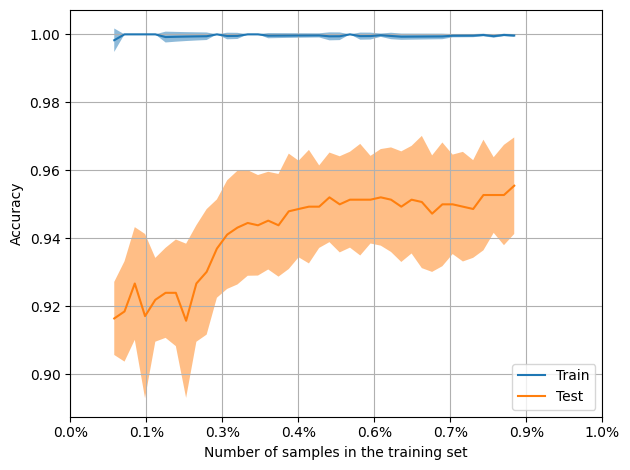

In [45]:
fig, ax = plt.subplots()
display.plot(ax = ax)
ax.set_xticks(ax.get_xticks())

xticklabels = [
    f'{(i/ax.get_xticks().max()):.1f}%'
    for i in ax.get_xticks()
]

ax.set_xticklabels(xticklabels)
plt.tight_layout()
plt.grid();

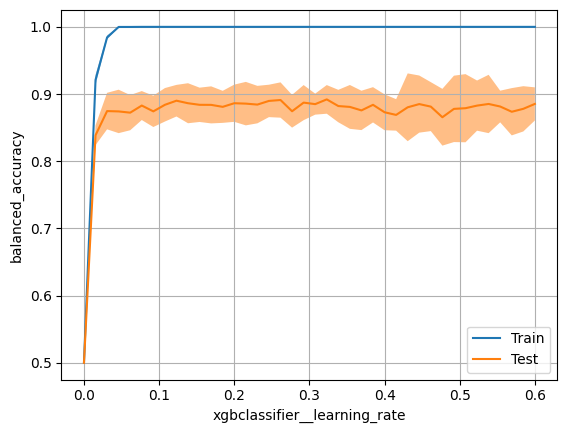

In [46]:
from sklearn.model_selection import ValidationCurveDisplay, validation_curve

param_name, param_range = "xgbclassifier__learning_rate", np.linspace(0., 0.6, 40)
train_scores, test_scores = validation_curve(
    XGB_pipeline, 
    X_train_strat, y_train_strat, 
    param_name = param_name, 
    param_range = param_range,
    n_jobs = -1,
    scoring = 'balanced_accuracy'
)

display = ValidationCurveDisplay(
    param_name = param_name, 
    param_range = param_range,
    train_scores = train_scores, test_scores=test_scores, 
    score_name="balanced_accuracy"
)
display.plot()
plt.grid();

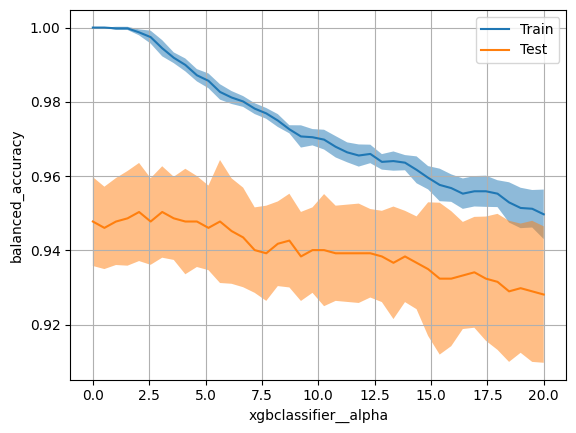

In [47]:
from sklearn.model_selection import ValidationCurveDisplay, validation_curve

param_name, param_range = "xgbclassifier__alpha", np.linspace(0, 20, 40)
train_scores, test_scores = validation_curve(
    XGB_pipeline, 
    X_train_strat, y_train_strat, 
    param_name = param_name, 
    param_range = param_range,
    n_jobs = -1,
    scoring = 'accuracy'
)

display = ValidationCurveDisplay(
    param_name = param_name, 
    param_range = param_range,
    train_scores = train_scores, 
    test_scores = test_scores, 
    score_name = "balanced_accuracy"
)

display.plot()
plt.grid();

## Hyperparameters tunning by GridSearchCV

In [48]:
from sklearn.model_selection import GridSearchCV
import numpy as np

In [ ]:
param_grid = {
    "preprocessor__num-pipe__simpleimputer__strategy": ["mean", "median"],
    "preprocessor__num-pipe__standardscaler__with_mean": [True, False],
    "preprocessor__num-pipe__standardscaler__with_std": [True, False],
    'xgbclassifier__learning_rate': np.linspace(0.01, 0.17, 20),
    'xgbclassifier__alpha': np.linspace(0.4, 0.5, 20),
}

XGB_search = GridSearchCV(
        XGB_pipeline, 
        param_grid, 
        cv = 5, 
        scoring = 'balanced_accuracy', 
        n_jobs = -1, 
        verbose = 1
) 

XGB_search.fit(X_train_strat, y_train_strat)
best_XGBClassifier = XGB_search.best_estimator_
XGB_search.best_params_

Fitting 5 folds for each of 3200 candidates, totalling 16000 fits


{'preprocessor__num-pipe__simpleimputer__strategy': 'mean',
 'preprocessor__num-pipe__standardscaler__with_mean': True,
 'preprocessor__num-pipe__standardscaler__with_std': True,
 'xgbclassifier__alpha': np.float64(0.4),
 'xgbclassifier__learning_rate': np.float64(0.17)}

In [51]:
best_XGBClassifier.fit(X_train_strat, y_train_strat)
y_test_pred = best_XGBClassifier.predict(X_test_strat)
y_train_pred = best_XGBClassifier.predict(X_train_strat)
display_fun(y_train_strat, y_test_strat, y_train_pred, y_test_pred)

         accuracy    balanced_accuracy_score
-----  ----------  -------------------------
Test     0.972603                   0.935836
Train    1                          1



After hyperparameter tuning, I was able to improve the model's accuracy on the test set. The improvement was modest, but still a positive step forward.

In [52]:
best_XGBClassifier = XGB_search.best_estimator_
best_XGBClassifier.fit(X, y)
y_pred = best_XGBClassifier.predict(X)
accuracy_score(y, y_pred)

1.0

# Competition

I worked on this problem as part of a project during the WBS Bootcamp. In this section, I submitted the model's output based on a test input. I'm keeping it here for my records.

In [319]:
test_url = "https://drive.google.com/file/d/16FMptqS3oavXB0aFwhEd64xblnet6Yt4/view?usp=drive_link"
test_path = "https://drive.google.com/uc?export=download&id="+test_url.split('/')[-2]
test_data = pd.read_csv(test_path)
test_data = test_data.set_index("Id")

In [315]:
submission = test_data.copy()
submission["Expensive"] = best_XGBClassifier.predict(submission)

output_folder = 'output'
if not os.path.isdir(output_folder):
   os.makedirs(output_folder)
    
output_path = os.path.join(output_folder, 'submission_classification_dummy.csv')
submission["Expensive"].to_csv(output_path)